In [1]:
import sklearn
print(sklearn.__version__)

1.3.0


In [2]:
import numpy as np
print(np.__version__)

1.24.4


In [3]:
import scipy
print(scipy.__version__)

1.10.1


In [4]:
import sys
print(sys.version)

3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]


In [50]:
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import warnings
warnings.filterwarnings("ignore")

In [9]:
with open('../data/processed_data/data_v2.pkl', 'rb') as f:
    data_reload = pickle.load(f)

X_train = data_reload['X_train']
X_test  = data_reload['X_test']
X_val   = data_reload['X_val']
y_train = data_reload['y_train']
y_test  = data_reload['y_test']
y_val   = data_reload['y_val']

In [10]:
X_val.shape

(1326, 31931)

In [11]:
len(y_val)

1326

In [12]:
with open('../data/processed_data/data_processed_pca.pkl', 'rb') as f:
    data_reload_pca = pickle.load(f)

X_train_pca = data_reload_pca['X_train']
X_test_pca  = data_reload_pca['X_test']
X_val_pca   = data_reload_pca['X_val']
y_train_pca = data_reload_pca['y_train']
y_test_pca  = data_reload_pca['y_test']
y_val_pca   = data_reload_pca['y_val']

In [13]:
X_val_pca.shape

(1326, 20)

In [14]:
len(y_val_pca)

1326

In [15]:
# Check for null values in X_val_pca
null_values = np.isnan(X_val_pca).sum()
print("Null values in X_val_pca:")
print(null_values)

Null values in X_val_pca:
0


In [16]:
with open('../data/processed_data/data_processed_pca_hard_ham.pkl', 'rb') as f:
    data_reload_hard_ham_pca = pickle.load(f)

X_train_hard_ham_pca = data_reload_hard_ham_pca['X_train']
X_test_hard_ham_pca  = data_reload_hard_ham_pca['X_test']
X_val_hard_ham_pca   = data_reload_hard_ham_pca['X_val']
y_train_hard_ham_pca = data_reload_hard_ham_pca['y_train']
y_test_hard_ham_pca  = data_reload_hard_ham_pca['y_test']
y_val_hard_ham_pca   = data_reload_hard_ham_pca['y_val']

In [17]:
X_val_hard_ham_pca.shape

(433, 20)

In [18]:
len(y_val_hard_ham_pca)

433

In [19]:
# Define the baseline model(most_frequent class classifier)
baseline_model = DummyClassifier(strategy='most_frequent')


# try predict
def cv_baseline(X_train, y_train):
    cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=10, scoring='accuracy')
    print("Cross-Validation Scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean())

def training_baseline(X_train, y_train):
    baseline_model.fit(X_train, y_train)

def validation_baseline(X_val, y_val):
    y_val_pred = baseline_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print("Validation Accuracy:", val_accuracy)

def prediction_baseline(X_test, y_test):
    y_pred = baseline_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)

cv_baseline(X_train, y_train)
training_baseline(X_train, y_train)

validation_baseline(X_val, y_val)

prediction_baseline(X_test, y_test)

import numpy as np
print("Training Label distribution:", np.bincount(y_train)/ len(y_train))
print("Validation Label distribution:", np.bincount(y_val)/ len(y_val))
print("Testing Label distribution:", np.bincount(y_test)/ len(y_test))


# Another model
param_dist_svc = {
    'C': randint(1, 100),            # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],      # Kernel coefficient
    'degree': randint(1, 10),        # Degree of the polynomial kernel
}
# # try predict
# def cv_svc(X_train, y_train):
#     cv_scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
#     print("Cross-Validation Scores:", cv_scores)
#     print("Mean CV Accuracy:", cv_scores.mean())

# def training_svc(X_train, y_train):
#     svc.fit(X_train, y_train)

# def validation_svc(X_val, y_val):
#     y_val_pred = svc.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)
#     print("Validation Accuracy:", val_accuracy)

# def prediction_svc(X_test, y_test):
#     y_pred = svc.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_pred)
#     print("Test Accuracy:", test_accuracy)

def workflow(model, param_dist, X_train, y_train, X_val, y_val, X_test, y_test):
    start_time = time.time()
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_jobs=10, n_iter=10, cv=5)
    random_search.fit(X_val, y_val)
    print("--- %s seconds ---" % (time.time() - start_time))
    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    # Train the model
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)
    # Predict
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)

print("==================================")
print("SVC: tokenized dataset:")
workflow(SVC(), param_dist_svc, X_train, y_train, X_val, y_val, X_test, y_test)
print("==================================")
print("SVC: PCA processed dataset:")
workflow(SVC(), param_dist_svc, X_train_pca, y_train_pca, X_val_pca, y_val_pca, X_test_pca, y_test_pca)

# Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 11)
}
# def training_rf(X_train, y_train):
#     rf_classifier.fit(X_train, y_train)

# def validation_rf(X_val, y_val):
#     y_val_pred = rf_classifier.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)
#     print("Validation Accuracy:", val_accuracy)

# def prediction_rf(X_test, y_test):
#     y_pred = rf_classifier.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_pred)
#     print("Test Accuracy:", test_accuracy)

print("==================================")
print("Random Forest: tokenized dataset:")
workflow(RandomForestClassifier(n_estimators=100, random_state=42), param_dist_rf, X_train, y_train, X_val, y_val, X_test, y_test)
print("==================================")
print("Random Forest: PCA processed dataset:")
workflow(RandomForestClassifier(n_estimators=100, random_state=42), param_dist_rf, X_train_pca, y_train_pca, X_val_pca, y_val_pca, X_test_pca, y_test_pca)

# Overfitting analysis

Cross-Validation Scores: [0.73344103 0.73344103 0.73344103 0.73344103 0.73344103 0.73462783
 0.73462783 0.73462783 0.73462783 0.73462783]
Mean CV Accuracy: 0.7340344328204484
Validation Accuracy: 0.7051282051282052
Test Accuracy: 0.7368024132730016
Training Label distribution: [0.73403395 0.26596605]
Validation Label distribution: [0.70512821 0.29487179]
Testing Label distribution: [0.73680241 0.26319759]
SVC: tokenized dataset:
--- 36.81401181221008 seconds ---
Best Hyperparameters: {'C': 80, 'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}
Test Accuracy: 0.9969834087481146
SVC: PCA processed dataset:
--- 0.47981786727905273 seconds ---
Best Hyperparameters: {'C': 60, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.9826546003016591
Random Forest: tokenized dataset:
--- 13.144335985183716 seconds ---
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 7, 'n_estimators': 52}
Test Accuracy: 0.9909502262443439
Random Forest: PCA processed dataset:
--- 14.61127

# Naive Bayes

## For Data_v2

In [20]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Define hyperparameter grid for grid search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val, y_val)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 0.7794759273529053 seconds ---
Best Hyperparameters: {'alpha': 0.001}


In [22]:
# Initialize Naive Bayes classifier with best hyperparameters
nb_best = MultinomialNB(**grid_search.best_params_)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(nb_best, X_val, y_val, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1-Score (after hyperparameter tuning):", cv_scores.mean())

--- 0.1696934700012207 seconds ---
Mean CV F1-Score (after hyperparameter tuning): 0.9817147764516185


In [23]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(nb_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean Stratified CV F1-Score (after hyperparameter tuning):", scv_scores.mean())

--- 0.1904468536376953 seconds ---
Mean Stratified CV F1-Score (after hyperparameter tuning): 0.9817147764516185


In [20]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
nb_best.fit(X_train, y_train)
y_test_pred = nb_best.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

--- 0.013959646224975586 seconds ---
Test Accuracy: 0.9894419306184012
Test Precision: 0.9919440252270525
Test Recall: 0.9808635874394747
Test F1-score: 0.986235389374468
Test ROC AUC: 0.9808635874394745


Test ROC AUC: 0.9991700222598269


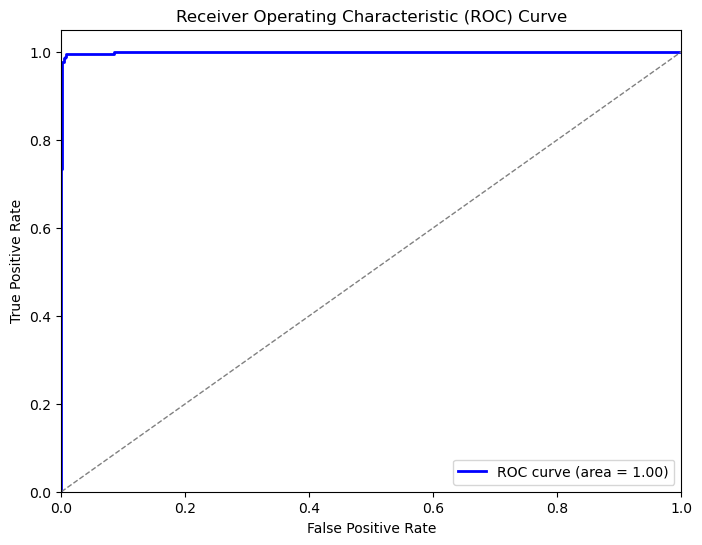

In [21]:
# Get predicted probabilities for the positive class
y_probabilities = nb_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

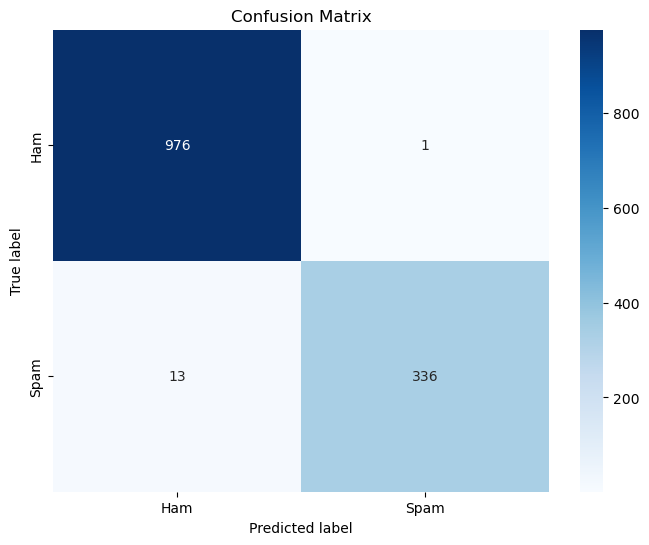

In [22]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

# K-Nearest Neighbors

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
# Define hyperparameter grid for grid search
param_grid = {'n_neighbors': [3, 5, 7]}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val, y_val)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 96.00115156173706 seconds ---
Best Hyperparameters: {'n_neighbors': 5}


In [26]:
# Initialize KNN classifier with best hyperparameters
knn_best = KNeighborsClassifier(**grid_search.best_params_)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(knn_best, X_val, y_val, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 36.51030683517456 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9466193986193987


In [27]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(knn_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 32.99894094467163 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9466193986193987


In [28]:
start_time = time.time()
knn_best.fit(X_train, y_train)
y_test_pred = knn_best.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

--- 163.0652196407318 seconds ---
Test Accuracy: 0.9879336349924586
Test Precision: 0.9882697947214076
Test Recall: 0.9656160458452722
Test F1-score: 0.9768115942028985
Test ROC AUC: 0.9807609400157784


Test ROC AUC: 0.9959600906816669


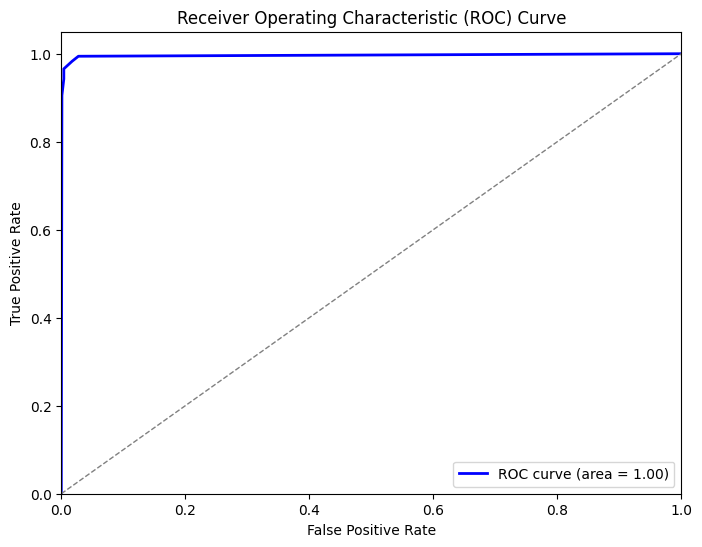

In [29]:
# Get predicted probabilities for the positive class
y_probabilities = knn_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

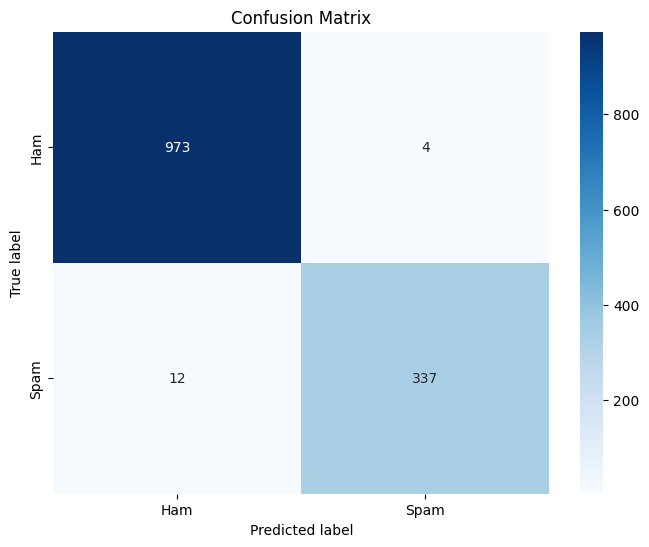

In [30]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## For Data_Processed_PCA

In [32]:
y_val_pca = np.array(y_val_pca)

In [33]:
# Define hyperparameter grid for grid search
param_grid = {'n_neighbors': [3, 5, 7]}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val_pca, y_val_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 0.4077942371368408 seconds ---
Best Hyperparameters: {'n_neighbors': 3}


In [34]:
# Initialize KNN classifier with best hyperparameters
knn_best = KNeighborsClassifier(**grid_search.best_params_)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(knn_best, X_val_pca, y_val_pca, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 0.13050317764282227 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9485632261159687


In [35]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(knn_best, X_val_pca, y_val_pca, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 0.0700526237487793 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9485632261159687


In [36]:
start_time = time.time()
knn_best.fit(X_train_pca, y_train_pca)
y_test_pred_pca = knn_best.predict(X_test_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_pca = accuracy_score(y_test_pca, y_test_pred_pca)
precision_pca = precision_score(y_test_pca, y_test_pred_pca)
recall_pca = recall_score(y_test_pca, y_test_pred_pca)
f1_pca = f1_score(y_test_pca, y_test_pred_pca)
roc_auc_pca = roc_auc_score(y_test_pca, y_test_pred_pca)

print("Test Accuracy:", accuracy_pca)
print("Test Precision:", precision_pca)
print("Test Recall:", recall_pca)
print("Test F1-score:", f1_pca)
print("Test ROC AUC:", roc_auc_pca)

--- 0.03441047668457031 seconds ---
Test Accuracy: 0.978129713423831
Test Precision: 0.9705882352941176
Test Recall: 0.9455587392550143
Test F1-score: 0.9579100145137881
Test ROC AUC: 0.9676616623603627


Test ROC AUC: 0.9874330225560382


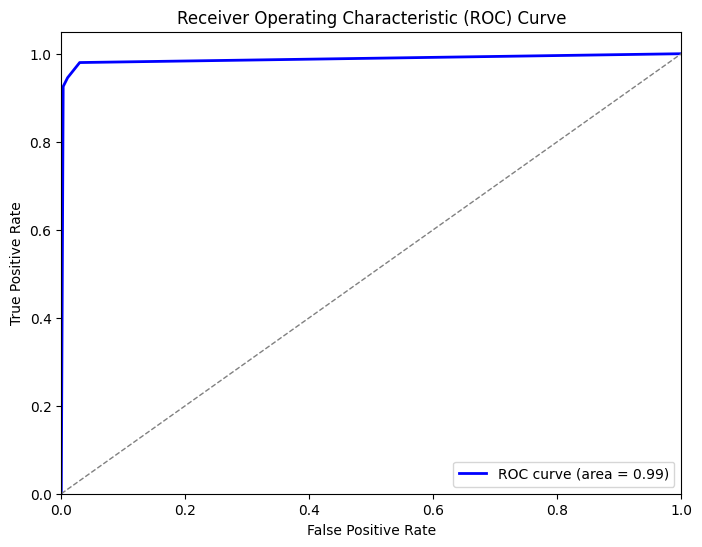

In [38]:
# Get predicted probabilities for the positive class
y_probabilities_pca = knn_best.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_probabilities_pca)

# Compute ROC AUC score
roc_auc_pca = roc_auc_score(y_test_pca, y_probabilities_pca)
print("Test ROC AUC:", roc_auc_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

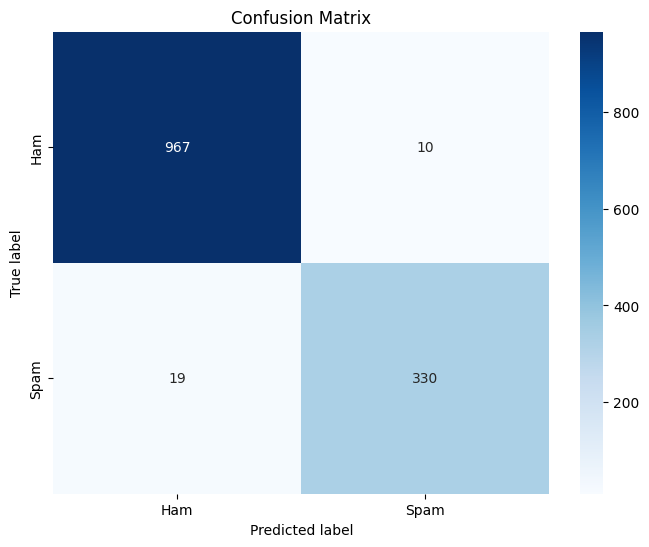

In [39]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_test_pred_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

# Transfer Learning

In [40]:
start_time = time.time()
knn_best.fit(X_train_hard_ham_pca, y_train_hard_ham_pca)
y_test_pred_hard_ham_pca = knn_best.predict(X_test_hard_ham_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_hard_ham_pca = accuracy_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)
precision_hard_ham_pca = precision_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
recall_hard_ham_pca = recall_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
f1_hard_ham_pca = f1_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

print("Test Accuracy:", accuracy_hard_ham_pca)
print("Test Precision:", precision_hard_ham_pca)
print("Test Recall:", recall_hard_ham_pca)
print("Test F1-score:", f1_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

--- 0.006934404373168945 seconds ---
Test Accuracy: 0.9607390300230947
Test Precision: 0.9274009784866966
Test Recall: 0.947337962962963
Test F1-score: 0.9369415675087593
Test ROC AUC: 0.947337962962963


Test ROC AUC: 0.9831299102132437


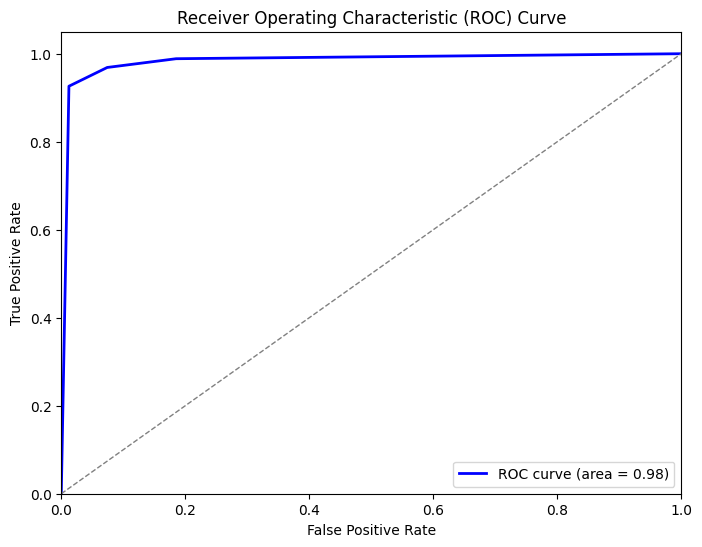

In [41]:
# Get predicted probabilities for the positive class
y_probabilities_hard_ham_pca = knn_best.predict_proba(X_test_hard_ham_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)

# Compute ROC AUC score
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_hard_ham_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

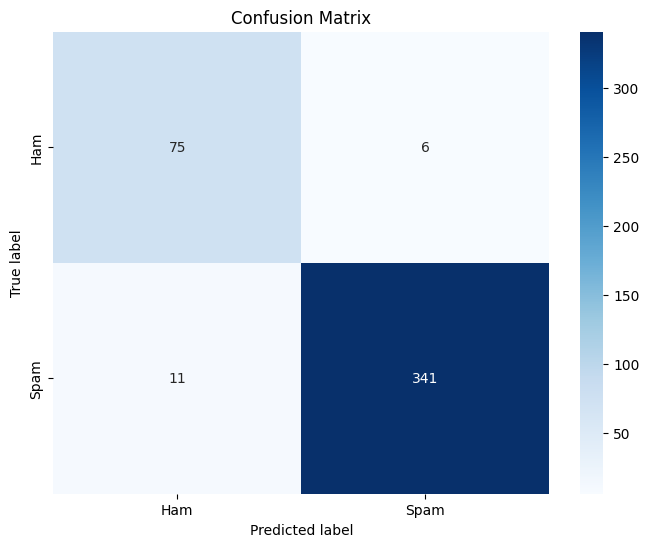

In [42]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

# Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [51]:
# Define hyperparameter grid for grid search
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'],
    #'max_iter': [100, 200, 300],
}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val, y_val)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 178.60105538368225 seconds ---
Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}


In [52]:
# Initialize logistic regression classifier with best hyperparameters
lr_best = LogisticRegression(**grid_search.best_params_, max_iter=1000)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(lr_best, X_val, y_val, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 21.037313222885132 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9776792330476543


In [53]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(lr_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 22.571177005767822 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9776792330476543


In [54]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
lr_best.fit(X_train, y_train)
y_test_pred = lr_best.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

--- 7.4727559089660645 seconds ---
Test Accuracy: 0.9947209653092006
Test Precision: 1.0
Test Recall: 0.9799426934097422
Test F1-score: 0.9898697539797395
Test ROC AUC: 0.9899713467048711


Test ROC AUC: 0.9998826886586328


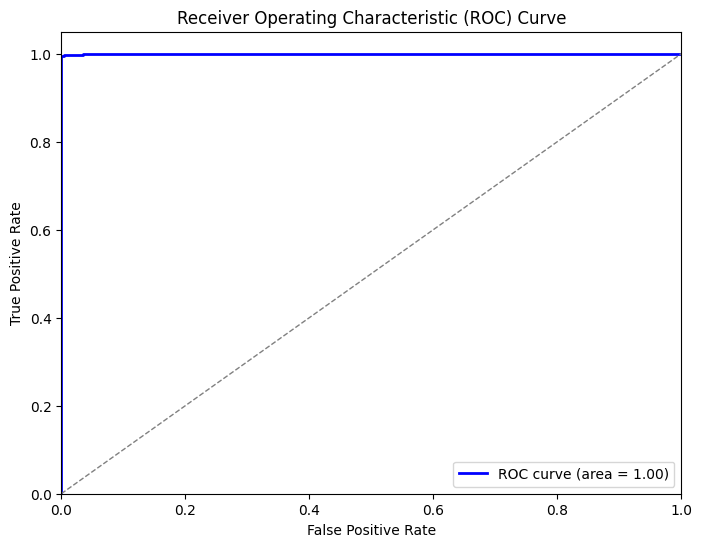

In [55]:
# Get predicted probabilities for the positive class
y_probabilities = lr_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

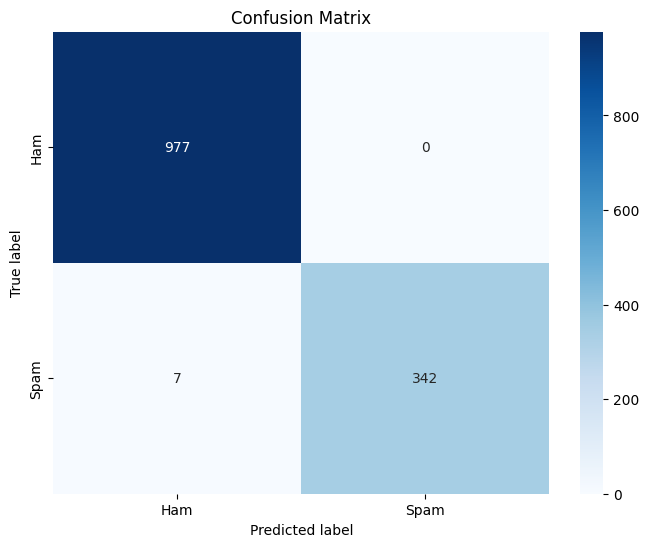

In [56]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## For Data_Processed_PCA

In [57]:
# Define hyperparameter grid for grid search
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'],
    #'max_iter': [100, 200, 300],
}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val_pca, y_val_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 20.660088539123535 seconds ---
Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}


In [58]:
# Initialize logistic regression classifier with best hyperparameters
lr_best = LogisticRegression(**grid_search.best_params_, max_iter=1000)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(lr_best, X_val_pca, y_val_pca, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 1.869142770767212 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9379809993250271


In [59]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(lr_best, X_val_pca, y_val_pca, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 1.9197735786437988 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9379809993250271


In [60]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
lr_best.fit(X_train_pca, y_train_pca)
y_test_pred_pca = lr_best.predict(X_test_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_pca = accuracy_score(y_test_pca, y_test_pred_pca)
precision_pca = precision_score(y_test_pca, y_test_pred_pca)
recall_pca = recall_score(y_test_pca, y_test_pred_pca)
f1_pca = f1_score(y_test_pca, y_test_pred_pca)
roc_auc_pca = roc_auc_score(y_test_pca, y_test_pred_pca)

print("Test Accuracy:", accuracy_pca)
print("Test Precision:", precision_pca)
print("Test Recall:", recall_pca)
print("Test F1-score:", f1_pca)
print("Test ROC AUC:", roc_auc_pca)

--- 0.917381763458252 seconds ---
Test Accuracy: 0.9683257918552036
Test Precision: 0.9723076923076923
Test Recall: 0.9054441260744985
Test F1-score: 0.9376854599406529
Test ROC AUC: 0.9481161264968194


Test ROC AUC: 0.9894742398958275


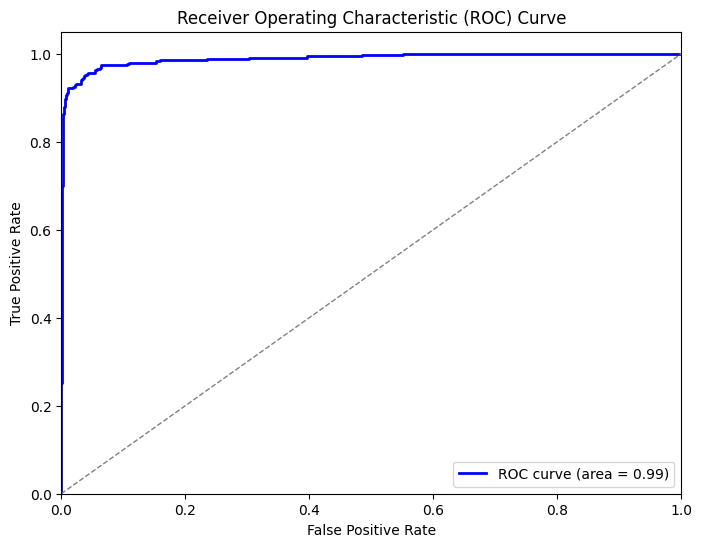

In [61]:
# Get predicted probabilities for the positive class
y_probabilities_pca = lr_best.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_probabilities_pca)

# Compute ROC AUC score
roc_auc_pca = roc_auc_score(y_test_pca, y_probabilities_pca)
print("Test ROC AUC:", roc_auc_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

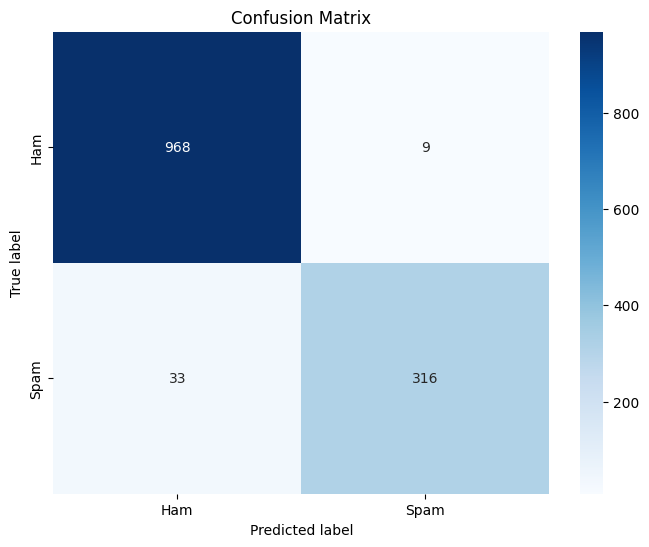

In [62]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_test_pred_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## Transfer Learning


In [63]:
start_time = time.time()
lr_best.fit(X_train_hard_ham_pca, y_train_hard_ham_pca)
y_test_pred_hard_ham_pca = lr_best.predict(X_test_hard_ham_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_hard_ham_pca = accuracy_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)
precision_hard_ham_pca = precision_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
recall_hard_ham_pca = recall_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
f1_hard_ham_pca = f1_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

print("Test Accuracy:", accuracy_hard_ham_pca)
print("Test Precision:", precision_hard_ham_pca)
print("Test Recall:", recall_hard_ham_pca)
print("Test F1-score:", f1_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

--- 0.1427474021911621 seconds ---
Test Accuracy: 0.9330254041570438
Test Precision: 0.9124093473005641
Test Recall: 0.859006734006734
Test F1-score: 0.8824614117360741
Test ROC AUC: 0.859006734006734


Test ROC AUC: 0.9658740179573513


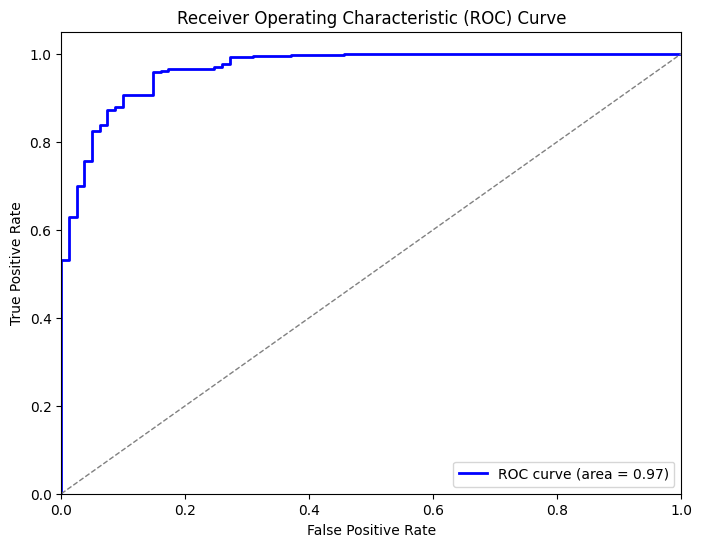

In [64]:
# Get predicted probabilities for the positive class
y_probabilities_hard_ham_pca = lr_best.predict_proba(X_test_hard_ham_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)

# Compute ROC AUC score
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_hard_ham_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

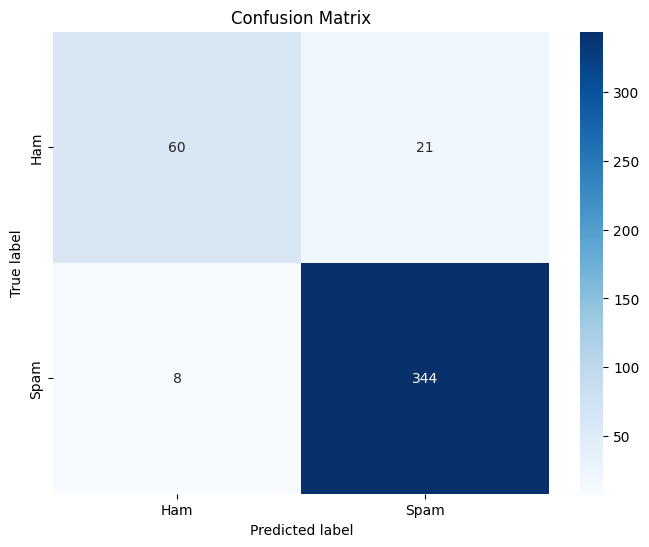

In [65]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## AdaBoost Classifier

In [66]:
from sklearn.ensemble import AdaBoostClassifier

In [67]:
# Define hyperparameter grid for grid search
param_grid = {'n_estimators': [10, 20, 30], 'learning_rate': [0.1, 0.5, 1.0]}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val, y_val)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 213.52411150932312 seconds ---
Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 30}


In [68]:
# Initialize AdaBoost classifier with best hyperparameters
adaboost_best = AdaBoostClassifier(**grid_search.best_params_)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(adaboost_best, X_val, y_val, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 34.45121908187866 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9635460790417486


In [69]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(adaboost_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 34.373286485672 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9635460790417486


In [70]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
adaboost_best.fit(X_train, y_train)
y_test_pred = adaboost_best.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

--- 11.388498306274414 seconds ---
Test Accuracy: 0.9826546003016591
Test Precision: 0.9815922920892495
Test Recall: 0.9734949688098471
Test F1-score: 0.9774507636559366
Test ROC AUC: 0.9734949688098471


Test ROC AUC: 0.9983371117361199


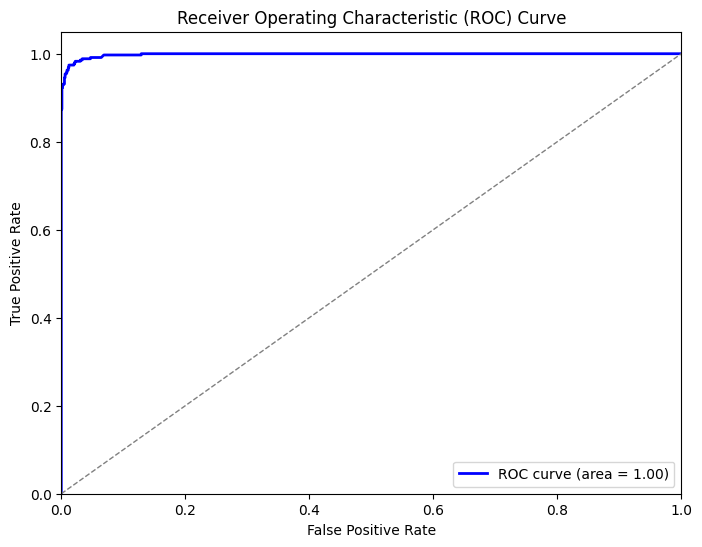

In [71]:
# Get predicted probabilities for the positive class
y_probabilities = adaboost_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

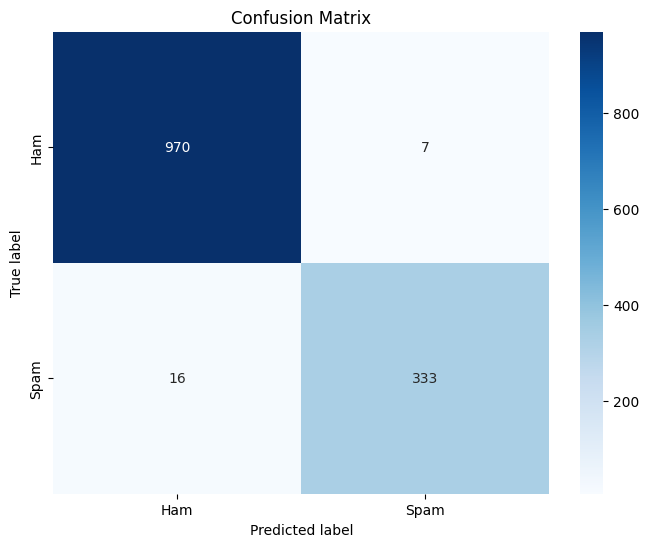

In [72]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## For Data_Processed_PCA

In [73]:
# Define hyperparameter grid for grid search
param_grid = {'n_estimators': [10, 20, 30], 'learning_rate': [0.1, 0.5, 1.0]}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val_pca, y_val_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 21.395261526107788 seconds ---
Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 30}


In [74]:
# Initialize AdaBoost classifier with best hyperparameters
adaboost_best = AdaBoostClassifier(**grid_search.best_params_)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(adaboost_best, X_val_pca, y_val_pca, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 3.589311122894287 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9408407548480833


In [75]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(adaboost_best, X_val_pca, y_val_pca, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 3.7730886936187744 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9408407548480833


In [76]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
adaboost_best.fit(X_train_pca, y_train_pca)
y_test_pred_pca = adaboost_best.predict(X_test_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_pca = accuracy_score(y_test_pca, y_test_pred_pca)
precision_pca = precision_score(y_test_pca, y_test_pred_pca, average='macro')
recall_pca = recall_score(y_test_pca, y_test_pred_pca, average='macro')
f1_pca = f1_score(y_test_pca, y_test_pred_pca, average='macro')
roc_auc_pca = roc_auc_score(y_test_pca, y_test_pred_pca)

print("Test Accuracy:", accuracy_pca)
print("Test Precision:", precision_pca)
print("Test Recall:", recall_pca)
print("Test F1-score:", f1_pca)
print("Test ROC AUC:", roc_auc_pca)

--- 1.4947779178619385 seconds ---
Test Accuracy: 0.9728506787330317
Test Precision: 0.9700623775476833
Test Recall: 0.9594747971246991
Test F1-score: 0.9646052869629177
Test ROC AUC: 0.9594747971246991


Test ROC AUC: 0.9899053590753519


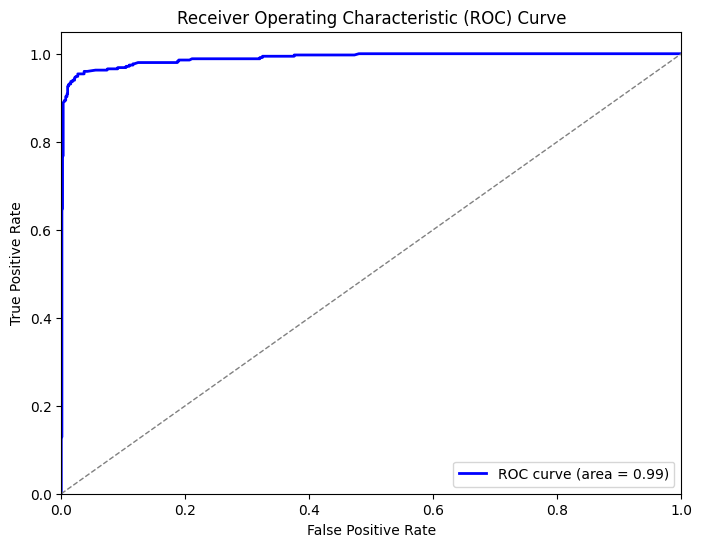

In [77]:
# Get predicted probabilities for the positive class
y_probabilities_pca = adaboost_best.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_probabilities_pca)

# Compute ROC AUC score
roc_auc_pca = roc_auc_score(y_test_pca, y_probabilities_pca)
print("Test ROC AUC:", roc_auc_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

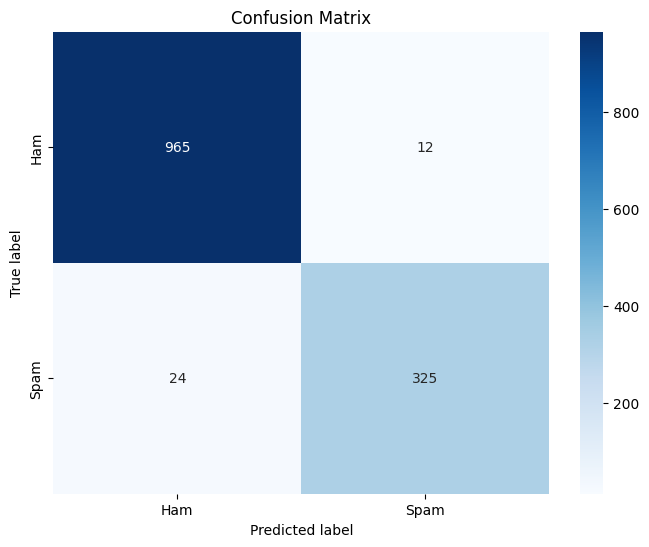

In [78]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_test_pred_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## Transfer Learning

In [79]:
start_time = time.time()
adaboost_best.fit(X_train_hard_ham_pca, y_train_hard_ham_pca)
y_test_pred_hard_ham_pca = adaboost_best.predict(X_test_hard_ham_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_hard_ham_pca = accuracy_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)
precision_hard_ham_pca = precision_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
recall_hard_ham_pca = recall_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
f1_hard_ham_pca = f1_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

print("Test Accuracy:", accuracy_hard_ham_pca)
print("Test Precision:", precision_hard_ham_pca)
print("Test Recall:", recall_hard_ham_pca)
print("Test F1-score:", f1_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

--- 0.5090286731719971 seconds ---
Test Accuracy: 0.9214780600461894
Test Precision: 0.8851062174149872
Test Recall: 0.847152076318743
Test F1-score: 0.8643483709273183
Test ROC AUC: 0.847152076318743


Test ROC AUC: 0.9561938832772167


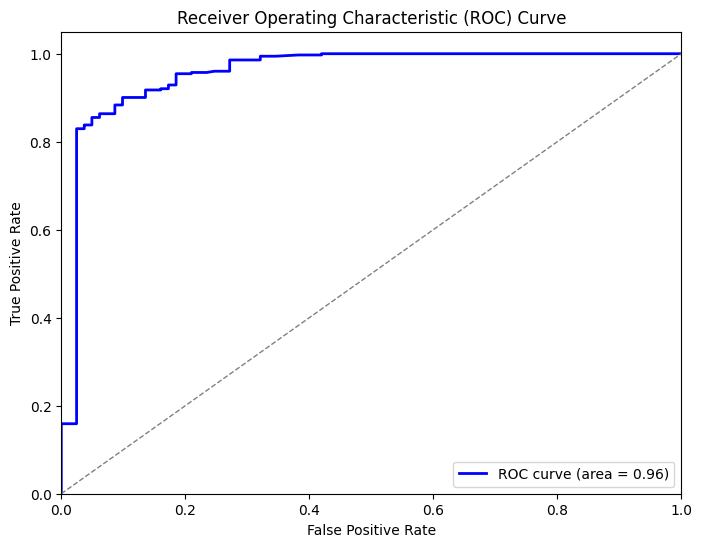

In [80]:
# Get predicted probabilities for the positive class
y_probabilities_hard_ham_pca = adaboost_best.predict_proba(X_test_hard_ham_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)

# Compute ROC AUC score
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_hard_ham_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

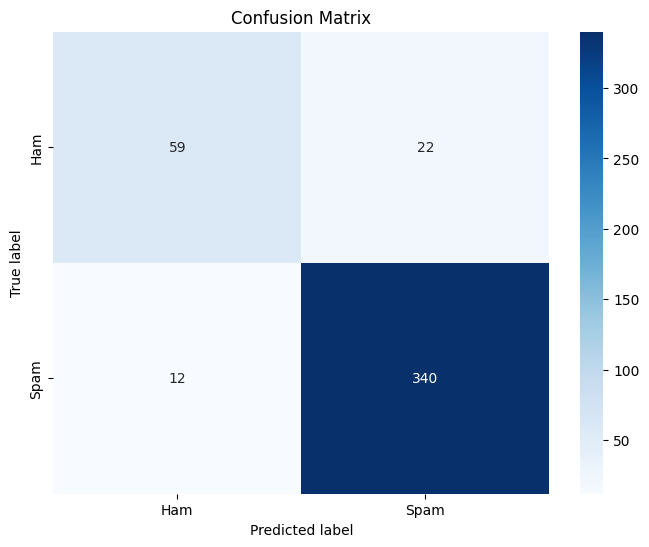

In [81]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

# Support Vector Machine

In [82]:
from sklearn.svm import SVC

In [83]:
# Define hyperparameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val, y_val)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 1503.9309437274933 seconds ---
Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


In [84]:
# Initialize AdaBoost classifier with best hyperparameters
svc_best = SVC(**grid_search.best_params_, probability=True)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(svc_best, X_val, y_val, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 40.18646502494812 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9842766356450567


In [85]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(svc_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 40.160287857055664 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9842766356450567


In [86]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
svc_best.fit(X_train, y_train)
y_test_pred = svc_best.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

--- 44.95495963096619 seconds ---
Test Accuracy: 0.9969834087481146
Test Precision: 0.9979612640163099
Test Recall: 0.994269340974212
Test F1-score: 0.9960967051599439
Test ROC AUC: 0.994269340974212


Test ROC AUC: 0.9994603678297109


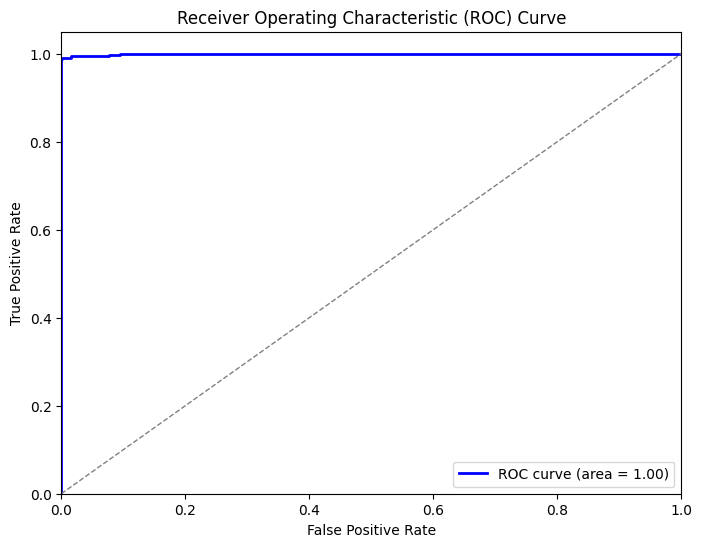

In [87]:
# Get predicted probabilities for the positive class
y_probabilities = svc_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

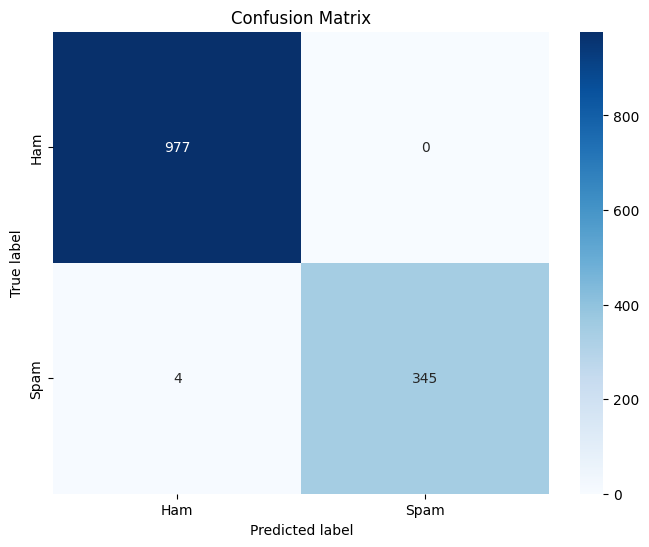

In [88]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## For Data_Processed_PCA

In [89]:
# Define hyperparameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val_pca, y_val_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 20.985788583755493 seconds ---
Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


In [90]:
# Initialize AdaBoost classifier with best hyperparameters
svc_best = SVC(**grid_search.best_params_, probability=True)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(svc_best, X_val_pca, y_val_pca, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 0.44842958450317383 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9391145391076898


In [91]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(svc_best, X_val_pca, y_val_pca, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 0.45591092109680176 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9391145391076898


In [92]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
svc_best.fit(X_train_pca, y_train_pca)
y_test_pred_pca = svc_best.predict(X_test_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_pca = accuracy_score(y_test_pca, y_test_pred_pca)
precision_pca = precision_score(y_test_pca, y_test_pred_pca, average='macro')
recall_pca = recall_score(y_test_pca, y_test_pred_pca, average='macro')
f1_pca = f1_score(y_test_pca, y_test_pred_pca, average='macro')
roc_auc_pca = roc_auc_score(y_test_pca, y_test_pred_pca)

print("Test Accuracy:", accuracy_pca)
print("Test Precision:", precision_pca)
print("Test Recall:", recall_pca)
print("Test F1-score:", f1_pca)
print("Test ROC AUC:", roc_auc_pca)

--- 0.9828610420227051 seconds ---
Test Accuracy: 0.969079939668175
Test Precision: 0.972198163866274
Test Recall: 0.9477070031938013
Test F1-score: 0.9591002752678012
Test ROC AUC: 0.9477070031938013


Test ROC AUC: 0.9893950547404047


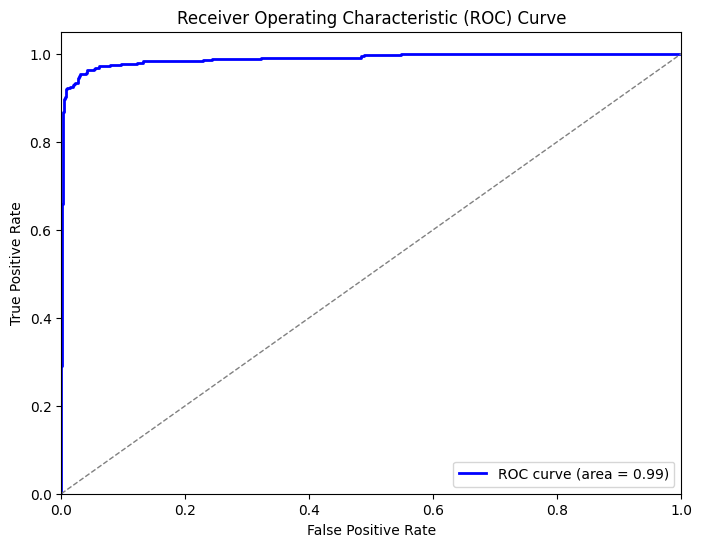

In [93]:
# Get predicted probabilities for the positive class
y_probabilities_pca = svc_best.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_probabilities_pca)

# Compute ROC AUC score
roc_auc_pca = roc_auc_score(y_test_pca, y_probabilities_pca)
print("Test ROC AUC:", roc_auc_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

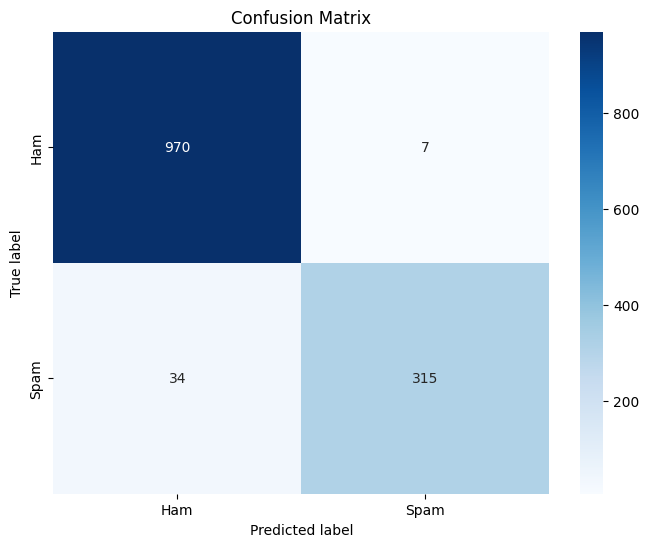

In [94]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_test_pred_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## Transfer Learning

In [95]:
start_time = time.time()
svc_best.fit(X_train_hard_ham_pca, y_train_hard_ham_pca)
y_test_pred_hard_ham_pca = svc_best.predict(X_test_hard_ham_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_hard_ham_pca = accuracy_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)
precision_hard_ham_pca = precision_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
recall_hard_ham_pca = recall_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
f1_hard_ham_pca = f1_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

print("Test Accuracy:", accuracy_hard_ham_pca)
print("Test Precision:", precision_hard_ham_pca)
print("Test Recall:", recall_hard_ham_pca)
print("Test F1-score:", f1_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

--- 0.16916823387145996 seconds ---
Test Accuracy: 0.9399538106235565
Test Precision: 0.9656084656084656
Test Recall: 0.8395061728395061
Test F1-score: 0.8866035455278001
Test ROC AUC: 0.8395061728395061


Test ROC AUC: 0.9620510662177328


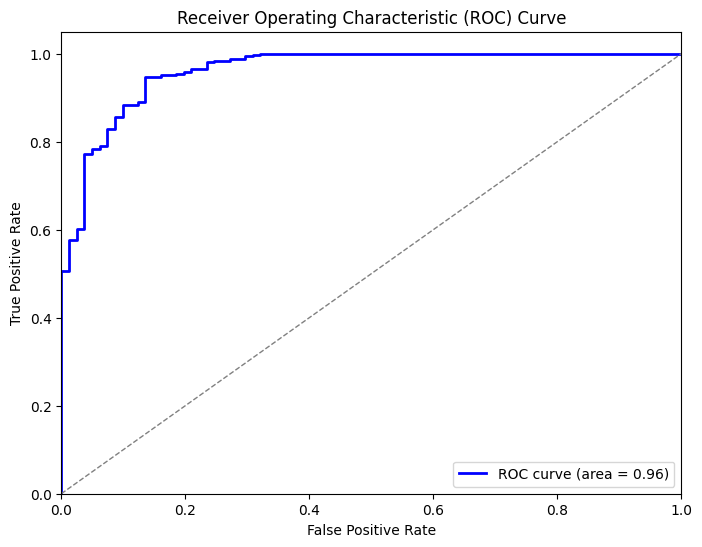

In [96]:
# Get predicted probabilities for the positive class
y_probabilities_hard_ham_pca = svc_best.predict_proba(X_test_hard_ham_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)

# Compute ROC AUC score
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_hard_ham_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

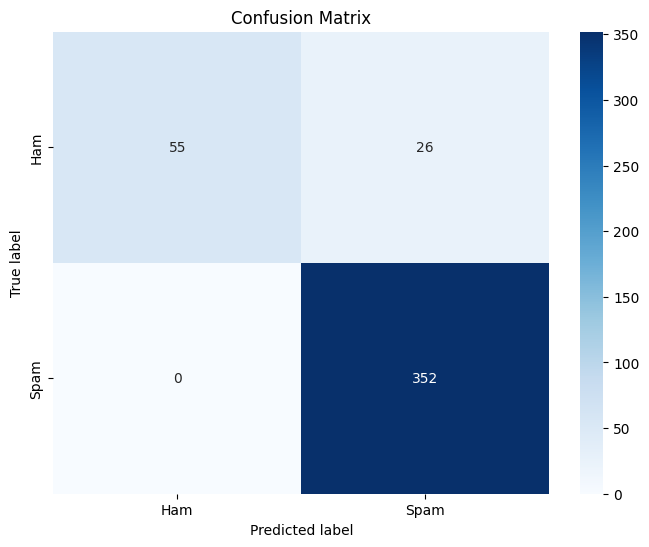

In [97]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

# Random Forest Classifier

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
# Define hyperparameter grid for grid search
param_grid = {'n_estimators': [10, 20, 30], 'max_depth': [None, 5, 10]}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val, y_val)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 8.575428247451782 seconds ---
Best Hyperparameters: {'max_depth': None, 'n_estimators': 30}


In [100]:
# Initialize AdaBoost classifier with best hyperparameters
rf_best = RandomForestClassifier(**grid_search.best_params_)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(rf_best, X_val, y_val, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 1.9008440971374512 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9576891354259776


In [101]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(rf_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 2.232027292251587 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9574200913807933


In [102]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
rf_best.fit(X_train, y_train)
y_test_pred = rf_best.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

--- 0.9701614379882812 seconds ---
Test Accuracy: 0.9917043740573153
Test Precision: 0.9934584178498986
Test Recall: 0.9851615817088156
Test F1-score: 0.9892155826180566
Test ROC AUC: 0.9851615817088157


Test ROC AUC: 0.9987608989568089


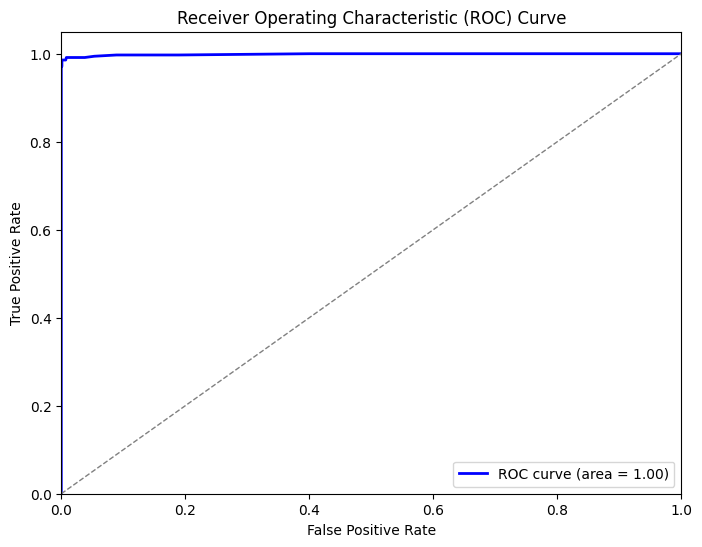

In [103]:
# Get predicted probabilities for the positive class
y_probabilities = rf_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

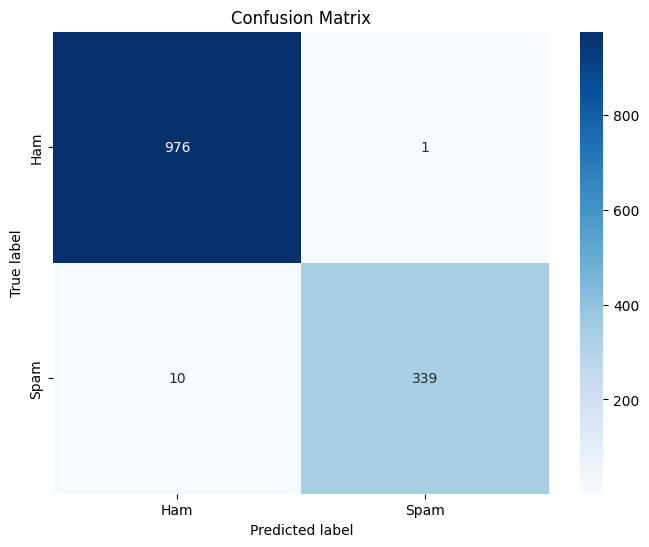

In [104]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## For Data_Processed_PCA

In [105]:
# Define hyperparameter grid for grid search
param_grid = {'n_estimators': [10, 20, 30], 'max_depth': [None, 5, 10]}
start_time = time.time()
# Perform grid search using training and validation sets
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1')
grid_search.fit(X_val_pca, y_val_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

--- 7.1637890338897705 seconds ---
Best Hyperparameters: {'max_depth': 10, 'n_estimators': 10}


In [106]:
# Initialize AdaBoost classifier with best hyperparameters
rf_best = RandomForestClassifier(**grid_search.best_params_)
start_time = time.time()
# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(rf_best, X_val_pca, y_val_pca, cv=10, scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean CV F1 Score (after hyperparameter tuning):", cv_scores.mean())

--- 0.4778025150299072 seconds ---
Mean CV F1 Score (after hyperparameter tuning): 0.9333263133263134


In [107]:
start_time = time.time()
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(rf_best, X_val_pca, y_val_pca, cv=StratifiedKFold(n_splits=10), scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))
# Print mean cross-validation accuracy
print("Mean SCV F1 Score (after hyperparameter tuning):", scv_scores.mean())

--- 0.4512920379638672 seconds ---
Mean SCV F1 Score (after hyperparameter tuning): 0.9331082497053309


In [108]:
start_time = time.time()
# Finally, train the model on the entire training set and evaluate it on the test set
rf_best.fit(X_train_pca, y_train_pca)
y_test_pred_pca = rf_best.predict(X_test_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_pca = accuracy_score(y_test_pca, y_test_pred_pca)
precision_pca = precision_score(y_test_pca, y_test_pred_pca, average='macro')
recall_pca = recall_score(y_test_pca, y_test_pred_pca, average='macro')
f1_pca = f1_score(y_test_pca, y_test_pred_pca, average='macro')
roc_auc_pca = roc_auc_score(y_test_pca, y_test_pred_pca)

print("Test Accuracy:", accuracy_pca)
print("Test Precision:", precision_pca)
print("Test Recall:", recall_pca)
print("Test F1-score:", f1_pca)
print("Test ROC AUC:", roc_auc_pca)

--- 0.22940921783447266 seconds ---
Test Accuracy: 0.975867269984917
Test Precision: 0.9740408589439322
Test Recall: 0.9633636680910218
Test F1-score: 0.9685380328559268
Test ROC AUC: 0.9633636680910219


Test ROC AUC: 0.9952386259322585


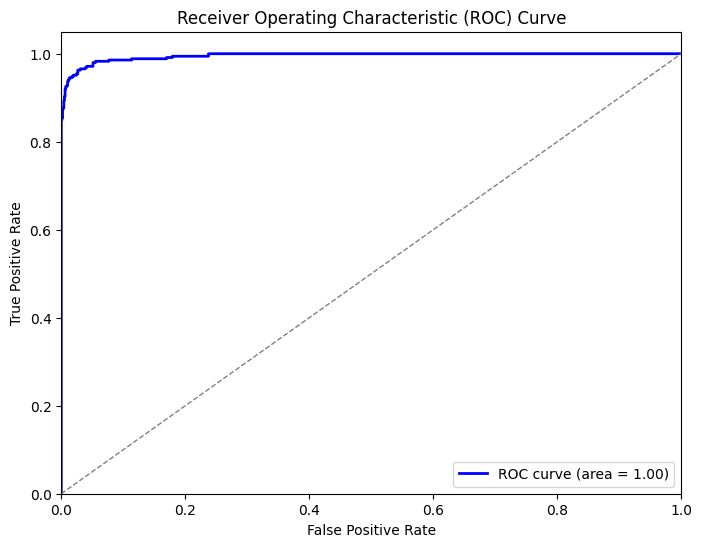

In [109]:
# Get predicted probabilities for the positive class
y_probabilities_pca = rf_best.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_probabilities_pca)

# Compute ROC AUC score
roc_auc_pca = roc_auc_score(y_test_pca, y_probabilities_pca)
print("Test ROC AUC:", roc_auc_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

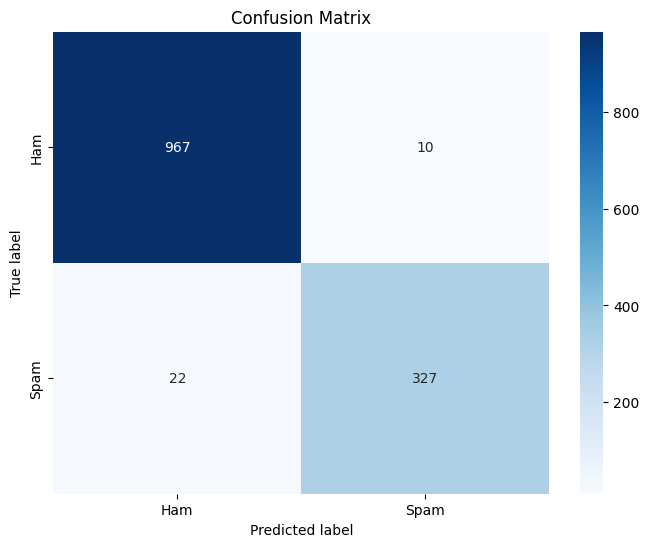

In [110]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_test_pred_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## Transfer Learning

In [111]:
start_time = time.time()
rf_best.fit(X_train_hard_ham_pca, y_train_hard_ham_pca)
y_test_pred_hard_ham_pca = rf_best.predict(X_test_hard_ham_pca)
print("--- %s seconds ---" % (time.time() - start_time))
# Compute evaluation metrics on the test set
accuracy_hard_ham_pca = accuracy_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)
precision_hard_ham_pca = precision_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
recall_hard_ham_pca = recall_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
f1_hard_ham_pca = f1_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca, average='macro')
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

print("Test Accuracy:", accuracy_hard_ham_pca)
print("Test Precision:", precision_hard_ham_pca)
print("Test Recall:", recall_hard_ham_pca)
print("Test F1-score:", f1_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

--- 0.07915210723876953 seconds ---
Test Accuracy: 0.9653579676674365
Test Precision: 0.9795640326975477
Test Recall: 0.9074074074074074
Test F1-score: 0.9385484374556499
Test ROC AUC: 0.9074074074074074


Test ROC AUC: 0.9928977272727273


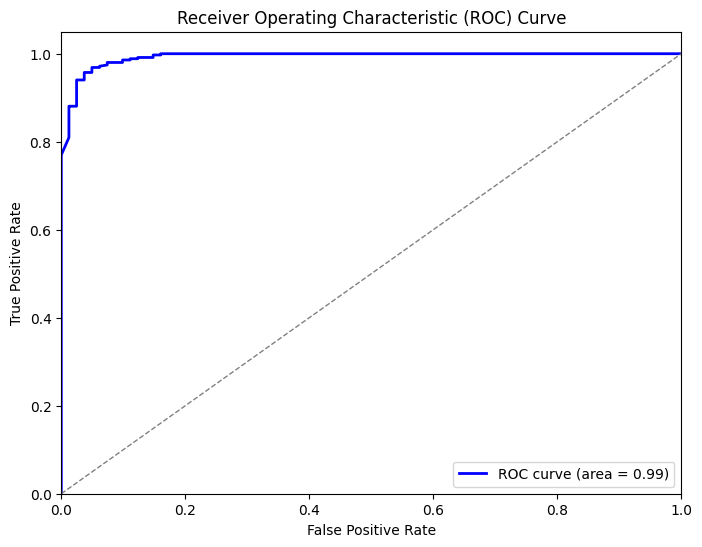

In [112]:
# Get predicted probabilities for the positive class
y_probabilities_hard_ham_pca = rf_best.predict_proba(X_test_hard_ham_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)

# Compute ROC AUC score
roc_auc_hard_ham_pca = roc_auc_score(y_test_hard_ham_pca, y_probabilities_hard_ham_pca)
print("Test ROC AUC:", roc_auc_hard_ham_pca)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_hard_ham_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

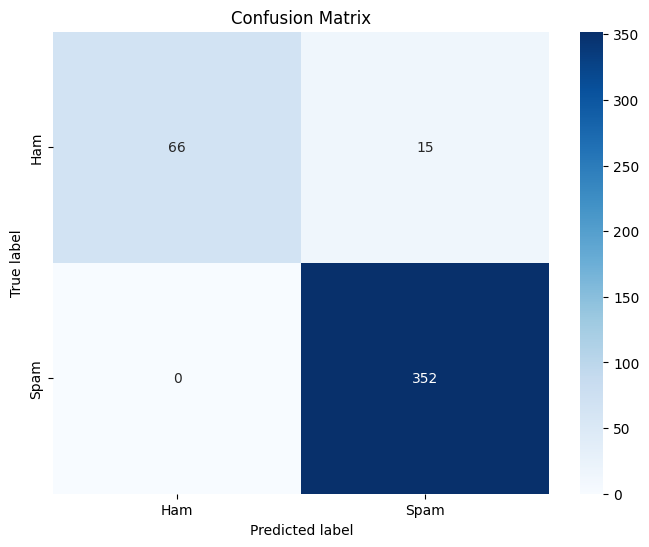

In [113]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_hard_ham_pca, y_test_pred_hard_ham_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()